In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# device agnostic code
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# loading the dataset
train_set = torchvision.datasets.FashionMNIST("./data", download=True,
                                              transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))

test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False,
                                            transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))


100%|██████████| 26421880/26421880 [00:02<00:00, 12392510.08it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 200468.13it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:06<00:00, 657597.43it/s] 


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8111298.64it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
class_names = train_set.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
len(train_set), len(test_set)

(60000, 10000)

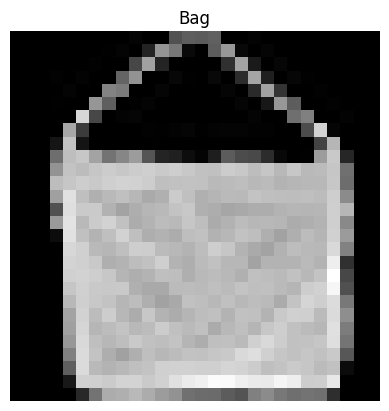

In [ ]:
 random_idx = torch.randint(0, len(train_set), size=[1]).item()
image, label = train_set[random_idx]
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis("Off");

In [ ]:
# preparing batches of data
batch_size = 32
train_data = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
test_data = torch.utils.data.DataLoader(test_set, batch_size, shuffle=False)

print(f"Length of train dataloader: {len(train_data)} batches of {batch_size}")
print(f"Length of test dataloader: {len(test_data)} batches of {batch_size}")

Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [ ]:
class FashionMNISTModel(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.layer_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, 3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*4*4,
                  out_features=output_shape)
    )

  def forward(self, x: torch.Tensor):
    x = self.layer_1(x)
    x = self.layer_2(x)
    x = self.classifier(x)
    return x


model = FashionMNISTModel(input_shape=1, hidden_units=10, output_shape=len(class_names)).to(device)
model

FashionMNISTModel(
  (layer_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=160, out_features=10, bias=True)
  )
)

In [ ]:
# loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

In [ ]:
def accuracy_func(y_pred, y_true):
  correct = torch.eq(y_pred, y_true).sum().item()
  accuracy = (correct/len(y_pred)) * 100
  return accuracy

In [ ]:
def train_step(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_func: nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_func,
               device: torch.device = device):

  global train_loss, train_accuracy, train_iteration_list
  train_loss, train_accuracy, train_iteration_list = [], [], []
  train_iteration = 0
  model.to(device)

  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)
    loss = loss_func(y_pred, y)
    train_loss.append(loss.item())
    accuracy = accuracy_func(y_pred.argmax(dim=1), y)
    train_accuracy.append(accuracy)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_iteration += 1
    train_iteration_list.append(train_iteration)

  print(f"Train Loss: {loss:.3f} | Train Accuracy: {accuracy:.2f}%")


def test_step(model: nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_func: nn.Module,
              accuracy_func,
              device: torch.device = device):

  global test_loss, test_accuracy, test_iteration_list
  test_loss, test_accuracy, test_iteration_list = [], [], []
  test_iteration = 0
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      test_pred = model(X)
      loss = loss_func(test_pred, y)
      test_loss.append(loss.item())
      accuracy = accuracy_func(test_pred.argmax(dim=1), y)
      test_accuracy.append(accuracy)
      test_iteration += 1
      test_iteration_list.append(test_iteration)

    print(f"Test Loss: {loss:.3f} | Test Accuracy: {accuracy:.2f}%")

In [ ]:
# Plotting
def plot(train_iteration_list, train_loss, train_accuracy, test_iteration_list, test_loss, test_accuracy):

  plt.plot(train_iteration_list, train_loss)
  plt.xlabel("Train Iteration"), plt.ylabel("Train Loss")
  plt.show()

  plt.plot(test_iteration_list, test_loss)
  plt.xlabel("Test Iteration"), plt.ylabel("Test Loss")
  plt.show()

  plt.plot(train_iteration_list, train_accuracy)
  plt.xlabel("Train Iteration"), plt.ylabel("Test Accuracy")
  plt.show()

  plt.plot(test_iteration_list, test_accuracy)
  plt.xlabel("Test Iteration"), plt.ylabel("Test Accuracy")
  plt.show()

In [ ]:
epochs = 5
for epoch in range(epochs):
  print(f"Epoch: {epoch}\n-----")
  train_step(model=model,
             data_loader=train_data,
             loss_func=loss_func,
             optimizer=optimizer,
             accuracy_func=accuracy_func)

  test_step(model=model,
            data_loader=test_data,
            loss_func=loss_func,
            accuracy_func=accuracy_func)

Epoch: 0
-----
Train Loss: 0.716 | Train Accuracy: 65.62%
Test Loss: 0.613 | Test Accuracy: 81.25%
Epoch: 1
-----
Train Loss: 0.452 | Train Accuracy: 78.12%
Test Loss: 0.388 | Test Accuracy: 75.00%
Epoch: 2
-----
Train Loss: 0.542 | Train Accuracy: 75.00%
Test Loss: 0.390 | Test Accuracy: 81.25%
Epoch: 3
-----
Train Loss: 0.687 | Train Accuracy: 78.12%
Test Loss: 0.285 | Test Accuracy: 81.25%
Epoch: 4
-----
Train Loss: 0.446 | Train Accuracy: 78.12%
Test Loss: 0.265 | Test Accuracy: 81.25%


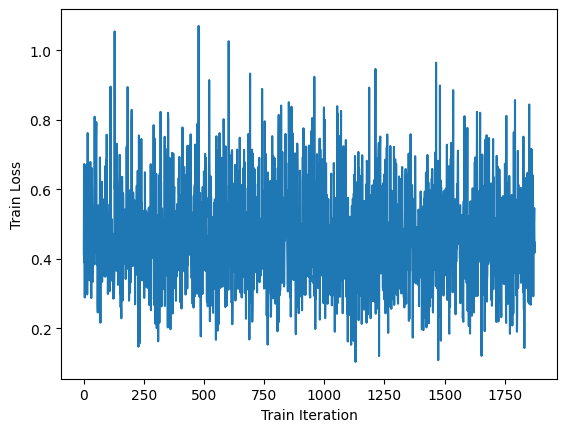

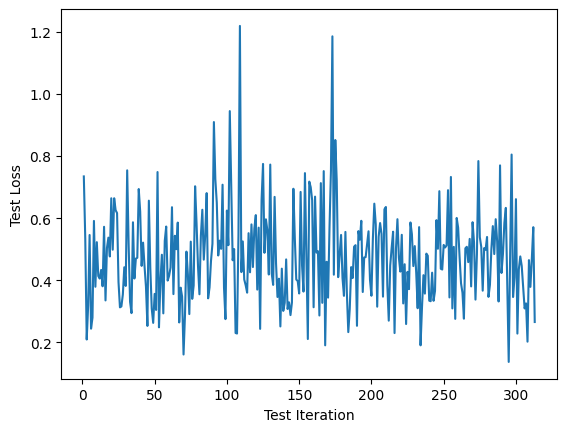

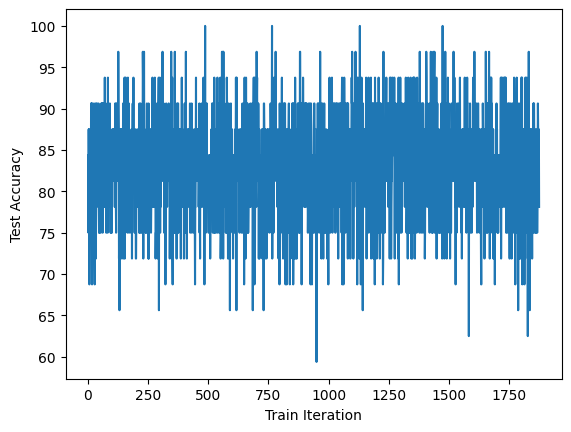

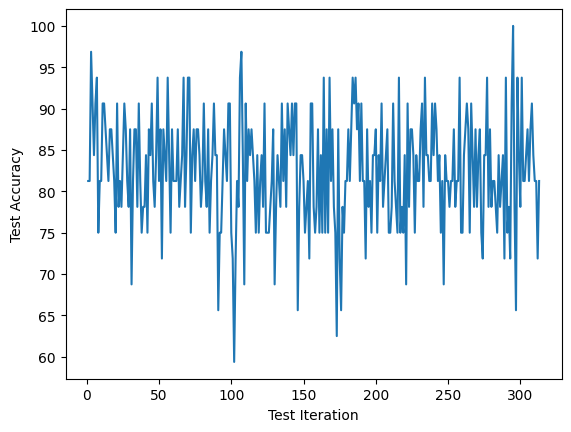

In [ ]:
plot(train_iteration_list, train_loss, train_accuracy, test_iteration_list, test_loss, test_accuracy)